# Testing it with various models

## Import all the things we need

In [1]:
#import all the things we need
# figures inline in the notebook
%matplotlib inline
from qutip import*
from scipy import *
from scipy.integrate import solve_ivp
import QCLSolver.data as QCLData
import QCLSolver.solver as QCLS
import numpy as np
import matplotlib.pyplot as plt
import time

In C:\ProgramData\Anaconda3\envs\qutip\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\ProgramData\Anaconda3\envs\qutip\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\envs\qutip\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\ProgramData\Anaconda3\envs\qutip\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\envs\qutip\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
  def randomcolor():
        "get random color"
        colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
        color = ""
        for i in range(6):
            color += colorArr[np.random.randint(0,14)]
        return "#"+color

In [3]:
def squareError(a,b):
    return np.real(np.sqrt(np.sum(np.power(a-b,2)))/len(a))

In [4]:
def reError(a,b):
    return np.real(np.sqrt(np.power((a-b)/a,2)))

## Testing it in Jaynes-Cumming model

With the rotating-wave approximation

$$H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$$

### Build up the qutip version

In [5]:
wc = 1.0  * 2 * pi  # cavity frequency
wa = 1.0  * 2 * pi  # atom frequency
g  = 0.05 * 2 * pi  # coupling strength
kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate
N = 2              # number of cavity fock states

tlist = np.linspace(0,25,101)

In [6]:
# intial state
psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
 #Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())


In [7]:
c_ops = []

c_ops.append(np.sqrt(kappa) * a)

c_ops.append(np.sqrt(gamma) * sm)

In [8]:
tic=time.time()
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])
toc=time.time()
t_qutip=toc-tic

In [9]:
n_c = output.expect[0]
n_a = output.expect[1]

### Build up the QCLS version

In [10]:
Hamilton=[['Aa',wc],['Bb',wa],['Ab',g],['aB',g]];print(Hamilton)
Co_ps=[['a',kappa],['b',gamma]];print(Co_ps)
T_o=['Aa','Bb'];print(T_o)

[['Aa', 6.283185307179586], ['Bb', 6.283185307179586], ['Ab', 0.3141592653589793], ['aB', 0.3141592653589793]]
[['a', 0.005], ['b', 0.05]]
['Aa', 'Bb']


In [11]:
data=QCLData.Data(Hamilton,Co_ps, T_o, 2)

In [12]:
tic=time.time()
sol2=QCLS.Solve(data, [0,1], (0,25), t_eval=tlist)
toc=time.time()
t_cluster=toc-tic
print(t_cluster,t_qutip)

0.008963823318481445 0.013000726699829102


Cavity Square Error: 4.99e-05
Atom Square Error: 4.99e-05


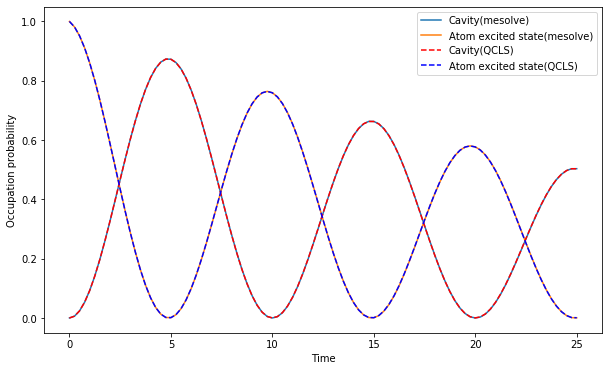

In [13]:
fig1, axes1 = plt.subplots(1, 1, figsize=(10,6))

axes1.plot(tlist, n_c,label="Cavity(mesolve)")
axes1.plot(tlist, n_a,label="Atom excited state(mesolve)")
axes1.plot(tlist, np.real(sol2.y[0]),color='red',linestyle='--',label="Cavity(QCLS)")
axes1.plot(tlist, np.real(sol2.y[1]),color='blue',linestyle='--',label="Atom excited state(QCLS)")
axes1.legend(loc=0)
axes1.set_xlabel('Time')
axes1.set_ylabel('Occupation probability')
print("Cavity Square Error:",end=' ');print('%.3g' % squareError(n_c,sol2.y[0]))
print("Atom Square Error:",end=' ');print('%.3g'%squareError(n_a,sol2.y[1]))

##  simulation of a two-qubit gate using a resonator as coupler

### Build up the qutip version

In [14]:
N = 2

wc = 5.0 * 2 * pi
w1 = 3.0 * 2 * pi
w2 = 2.0 * 2 * pi

g1 = 0.01 * 2 * pi
g2 = 0.0125 * 2 * pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * g2)

In [15]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1

sm1 = tensor(qeye(N), destroy(2), qeye(2))
n1 = sm1.dag() * sm1
sz1 = tensor(qeye(N), sigmaz(), qeye(2))


# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
n2 = sm2.dag() * sm2
sz2 = tensor(qeye(N), qeye(2), sigmaz())


In [16]:
# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 

In [17]:
# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0))

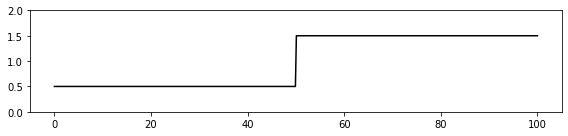

In [18]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

In [19]:
def wc_t(t,args=None):
    return wc

def w1_t(t,args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t,args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

In [20]:
tic=time.time()
output = mesolve(H_t, psi0, tlist, [], [n,n1,n2])
toc=time.time()
t_qutip=toc-tic

### Build up the QCLS version

In [21]:
Hc='Aa'
H1='Bb'
H2='Cc'
Hc1_1='Ab'
Hc1_2='aB'
Hc2_1='Ac'
Hc2_2='aC'
T_o=['Aa','Bb','Cc']

def wc_tc(t):
    return wc

def w1_tc(t):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_tc(t):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


In [22]:
H_t=[[Hc,wc_tc],[H1,w1_tc],[H2,w2_tc],[Hc1_1,g1],[Hc1_2,g1],[Hc2_1,g2],[Hc2_2,g2]]
print(H_t)

[['Aa', <function wc_tc at 0x000002C0D589E8B8>], ['Bb', <function w1_tc at 0x000002C0D589E5E8>], ['Cc', <function w2_tc at 0x000002C0D589EAF8>], ['Ab', 0.06283185307179587], ['aB', 0.06283185307179587], ['Ac', 0.07853981633974483], ['aC', 0.07853981633974483]]


In [23]:
data=QCLData.Data(H_t, [], T_o, 2)

In [24]:
tic=time.time()
sol2=QCLS.Solve(data, [0,1,0], (0,100), t_eval=tlist)
toc=time.time()
t_cluster=toc-tic
print(t_qutip,t_cluster)

0.2400362491607666 0.8395936489105225


Cavity Square Error 3.35e-05
Qubit 1 Square Error 4e-05
Qubit 2 Square Error 2.2e-05


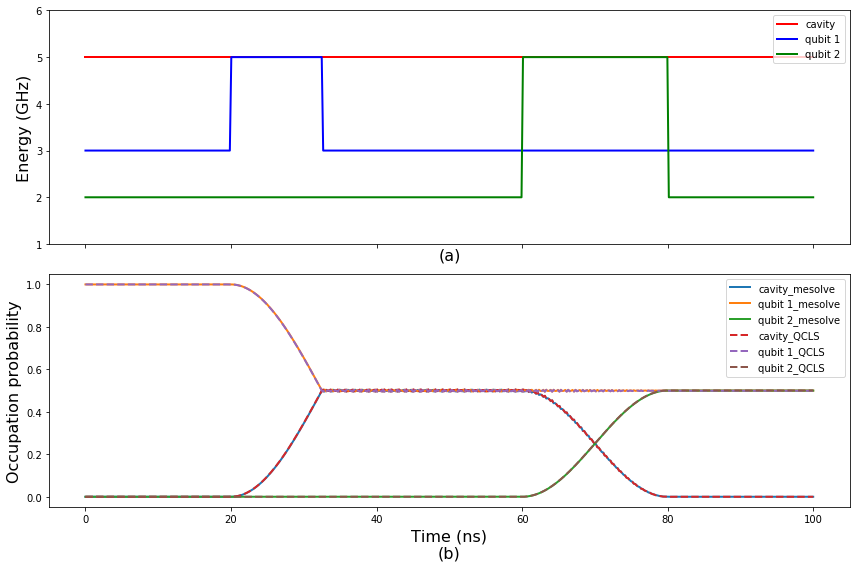

In [25]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()
axes[0].set_xlabel("(a)", fontsize=16)

axes[1].plot(tlist, np.real(output.expect[0]), linewidth=2, label="cavity_mesolve")
axes[1].plot(tlist, np.real(output.expect[1]), linewidth=2, label="qubit 1_mesolve")
axes[1].plot(tlist, np.real(output.expect[2]), linewidth=2, label="qubit 2_mesolve")
axes[1].plot(tlist, np.real(sol2.y[0]), linestyle='--',linewidth=2, label="cavity_QCLS")
axes[1].plot(tlist, np.real(sol2.y[1]), linestyle='--',linewidth=2, label="qubit 1_QCLS")
axes[1].plot(tlist, np.real(sol2.y[2]), linestyle='--',linewidth=2, label="qubit 2_QCLS")

axes[1].set_xlabel("Time (ns)\n(b)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()
print("Cavity Square Error",end=' ')
print('%.3g' % squareError(output.expect[0],sol2.y[0]))
print("Qubit 1 Square Error",end=' ')
print('%.3g'% squareError(output.expect[1],sol2.y[1]))
print("Qubit 2 Square Error",end=' ')
print('%.3g'%squareError(output.expect[2],sol2.y[2]))

## Cavity-enhanced second-harmonic generation 

The Hamiltonian of the model is descrided as
$$
H_{rot}=\hbar\Delta_{a}a^{\dagger}a+\hbar\Delta_{b}b^{\dagger}b+\hbar g_{nl}[b(a^{\dagger})^2+b^{\dagger}a^2]+E(a^{\dagger}+a).
$$

The evolution of the density matrix is descrided as
$$
\frac{d\rho}{dt}=-i[H_{rot},\rho]+\sum_{i=a,b}\kappa_i[2A_i\rho A_i^{\dagger}-A_i^{\dagger}A_i\rho-\rho A_i^{\dagger}A_i]
$$

### Build up the qutip version

In [35]:
Delta_a=0
Delta_b=0
kappa_a=2
kappa_b=2
initial=[0,0]
g_list=np.linspace(0.2,2,6)
E_list=np.linspace(0.333,2,20)

accuracy=0.001
t_pace=0.01
#sol3=np.zeros([4,np.size(E_list),2])

Build up the operator

In [36]:
def BuildOperator(E:float,g:float):
    Na=int(max(math.ceil(E*E+6*E),4)); Nb=int(Na//2)
    psi0=tensor(basis(Na,initial[0]),basis(Nb,initial[1]))
    a=tensor(destroy(Na),qeye(Nb))
    b=tensor(qeye(Na),destroy(Nb))
    H=Delta_a*a.dag()*a+Delta_b*b.dag()*b+g*(b*a.dag()*a.dag()+b.dag()*a*a)\
        +E*(a.dag()+a)
    c_ops=[]
    c_ops.append(np.sqrt(kappa_a)*a)
    c_ops.append(np.sqrt(kappa_b)*b)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[a.dag()*a,b.dag()*b,\
                a.dag()*a.dag()*a*a,b.dag()*b.dag()*b*b]}
    return operator

In [37]:
sol1=np.zeros([np.size(g_list),np.size(E_list),5])

In [38]:
n=0;
N=np.size(g_list)*np.size(E_list)
for i in range(0,np.size(g_list)):
    Time=10
    for j in range(0,np.size(E_list)):
        op=BuildOperator(E_list[j],g_list[i])
        tlist=np.linspace(0,Time,Time//t_pace)
        tic=time.time()
        output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])
        toc=time.time()
        t_qutip=toc-tic     
        n_a=output.expect[0];n_b=output.expect[1]
        '''
        while((math.fabs(n_a[int(-0.1//t_pace)]-n_a[-1])/(n_a[-1]))>accuracy):
            Time=Time*2
            tlist=np.linspace(0,Time,Time//t_pace)
            output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])
            n_a=output.expect[0];n_b=output.expect[1]
       
        if (math.fabs((n_a[int(-0.1//t_pace)]-n_a[-1]))/(n_a[-1])<(accuracy/100)) and (Time>2) :
                    Time=Time//2
         '''
        n=n+1
        sol1[i][j][0]=n_a[-1];sol1[i][j][1]=n_b[-1]
        sol1[i][j][2]=output.expect[2][-1]/pow(n_a[-1],2)
        sol1[i][j][3]=output.expect[3][-1]/pow(n_b[-1],2)
        sol1[i][j][4]=t_qutip
    print(str(Time)+"->complete: "+str(n/N*100)+'%')       

10->complete: 16.666666666666664%
10->complete: 33.33333333333333%
10->complete: 50.0%
10->complete: 66.66666666666666%
10->complete: 83.33333333333334%
10->complete: 100.0%


### Build up the QCLS version

In [39]:
H=[['Aa',Delta_a],['Bb',Delta_b],['AAb',1],['aaB',1],['A',2],['a',2]] 
Co_ps=[['a',kappa_a],['b',kappa_b]];
T_o=['Aa','Bb','AAaa','BBbb'];

order=4
#pick=0

In [40]:
data=QCLData.Data(H, Co_ps, T_o, order)
sol2=np.zeros([np.size(g_list),np.size(E_list),5])
#data.Debug()

In [41]:
n=0;
N=np.size(g_list)*np.size(E_list)
for i in range(0,np.size(g_list)):
    Time=10
    for j in range(0,np.size(E_list)):
        tlist=np.linspace(0,Time,Time//t_pace)
        data.SetCoefHOList([Delta_a,Delta_b,g_list[i],g_list[i],E_list[j],E_list[j]])
        tic=time.time()
        output=QCLS.Solve(data,initial,(0,Time),t_eval=tlist)
        toc=time.time()
        t_cluster=toc-tic   
        n_a=np.real(output.y[0]);n_b=np.real(output.y[1])
        '''
        while((math.fabs(n_a[int(-0.1//t_pace)]-n_a[-1])/(n_a[-1]))>accuracy):
            Time=Time*2
            tlist=np.linspace(0,Time,Time//t_pace)
            output=QCLS.Solve(data,initial,(0,Time),t_eval=tlist)
            n_a=np.real(output.y[0]);n_b=np.real(output.y[1])
       
        if (math.fabs((n_a[int(-0.1//t_pace)]-n_a[-1]))/(n_a[-1])<(accuracy/100)) and (Time>2) :
                    Time=Time//2
        '''
        n=n+1
        sol2[i][j][0]=n_a[-1];sol2[i][j][1]=n_b[-1]
        sol2[i][j][2]=np.real(output.y[2][-1])/pow(n_a[-1],2)
        sol2[i][j][3]=np.real(output.y[3][-1])/pow(n_b[-1],2)
        sol2[i][j][4]=t_cluster
        #if (i==pick):
           # sol3[order-2,j,0]=n_a[-1];sol3[order-2,j,1]=n_b[-1]
    print(str(Time)+"->complete: "+str(n/N*100)+'%')

10->complete: 16.666666666666664%
10->complete: 33.33333333333333%
10->complete: 50.0%
10->complete: 66.66666666666666%
10->complete: 83.33333333333334%
10->complete: 100.0%


qutip:6557.4750900268555ms	QCLS:388.99803161621094ms


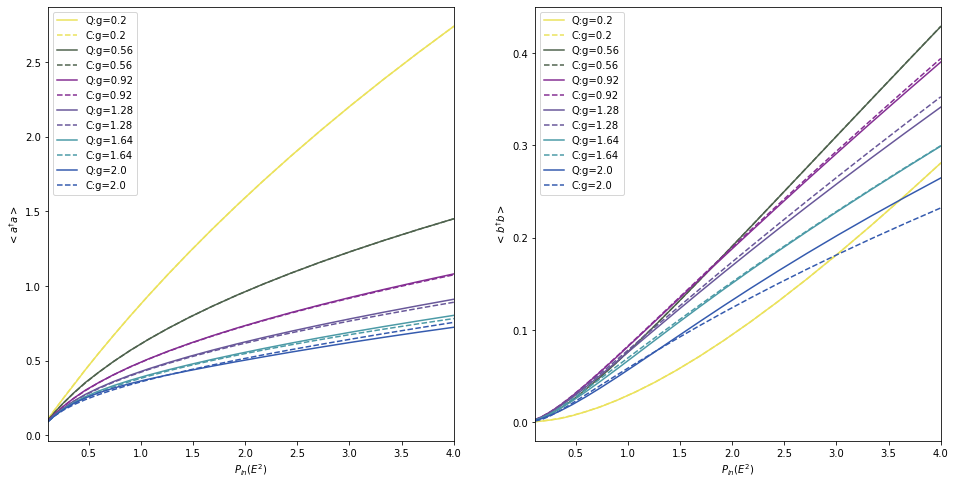

In [42]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol1[i,...,0],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol1[i,...,1],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[0].plot(E_list*E_list,sol2[i,...,0],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,1],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel(r'$<a^{\dagger}a>$')
axes[1].set_ylabel(r'$<b^{\dagger}b>$')    
print("qutip:"+str(t_qutip*1000)+'ms',end='\t')
print("QCLS:"+str(t_cluster*1000)+'ms')

Text(0, 0.5, 'Correlation b$g_{2}$')

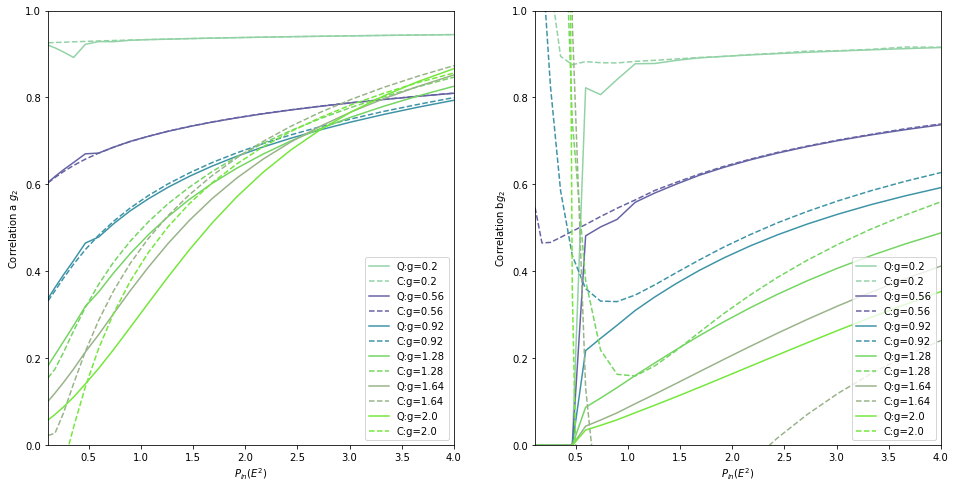

In [43]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_ylim(0,1);axes[1].set_ylim(0,1)
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol1[i,...,2],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol1[i,...,3],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[0].plot(E_list*E_list,sol2[i,...,2],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,3],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel('Correlation a '+r'$g_{2}$')
axes[1].set_ylabel('Correlation b'+r'$g_{2}$')

Text(0, 0.5, 'Time QCLS t/s')

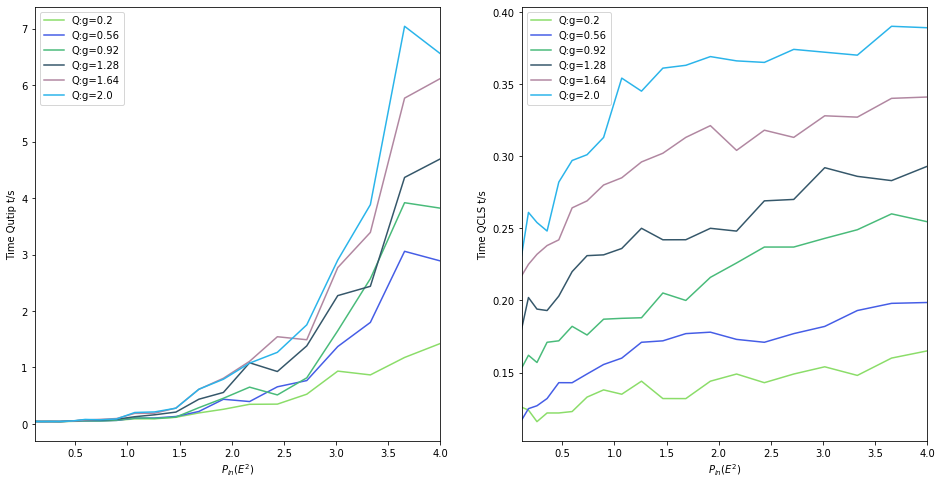

In [44]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol1[i,...,4],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,4],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel('Time Qutip t/s')
axes[1].set_ylabel('Time QCLS t/s')

(6, 20) (6, 20)


Text(0, 0.5, 'Mode B Population Relative error')

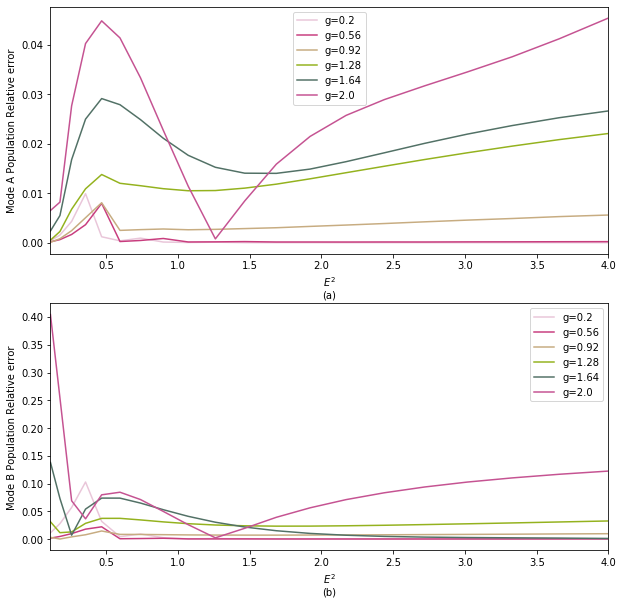

In [45]:
error_a=reError(sol1[...,0],sol2[...,0])
error_b=reError(sol1[...,1],sol2[...,1])
print(np.shape(error_a),np.shape(error_b))
fig, axes = plt.subplots(2,1 , figsize=(10,10))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$E^2$'+'\n(a)');axes[1].set_xlabel(r'$E^2$'+'\n(b)')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,error_a[i,...],color=cor,linestyle='-',label='g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,error_b[i,...],color=cor,linestyle='-',label='g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel('Mode A Population Relative error')
axes[1].set_ylabel('Mode B Population Relative error')    

Various order

In [66]:
delta_a=0.8
delta_b=1.6
kappa_a=1
kappa_b=2
psi0_l=[0,0]
E=2; g=0.85
H=[['Aa',delta_a],['Bb',delta_b],['AAb',g],['aaB',g],['A',E],['a',E]] 
Co_ps=[['a',kappa_a],['b',kappa_b]]
T_o=['Aa']
orders=range(2,8)

In [67]:
op=BuildOperator(E,g)
output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])

In [68]:
sol2=[]
for order in orders:
    print(order)
    data=QCLData.Data(H, Co_ps, T_o, order)
    sol=QCLS.Solve(data,psi0_l,(0,10),t_eval=tlist, rtol=1e-6)
    sol2=sol2+[sol]

2
3
4
5
6
7


Text(0, 0.5, 'Mode A Population')

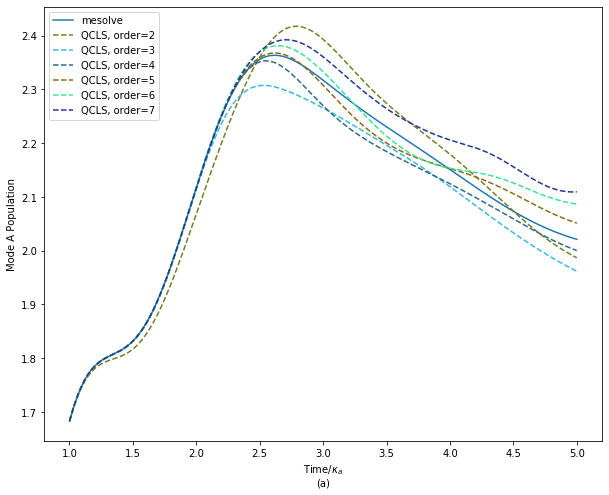

In [69]:
fig1, axes1 = plt.subplots(1, 1, figsize=(10,8))

axes1.plot(tlist[span:], output.expect[0][span:],label="mesolve")
for order in orders:
    cor=randomcolor()
    axes1.plot(tlist[span:], np.real(sol2[order-2].y[0][span:]),color=cor,linestyle='--',label="QCLS, order="+str(order))
axes1.legend(loc=2)
axes1.set_xlabel('Time/'+r'$\kappa_a$'+'\n(a)')
axes1.set_ylabel('Mode A Population')

Text(0, 0.5, 'RMSE')

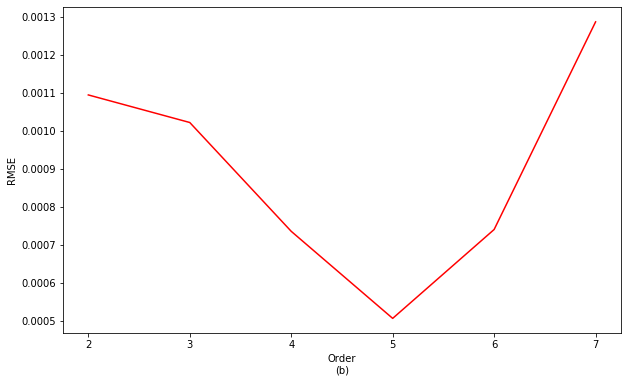

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))
RMSE=[]
for order in orders:
    RMSE+= [squareError(output.expect[0],sol2[order-2].y[0])]
axes.plot(orders, RMSE,color='red',linestyle='-')
axes.set_xlabel('Order\n(b)')
axes.set_ylabel('RMSE')

## Optical Parametric Oscillator

The Hamiltonian of the model is descrided as (resonance)
$$
H_{rot}=\hbar g_{nl}[b(a^{\dagger})^2+b^{\dagger}a^2]+E(b^{\dagger}+b).
$$

### Build up the qutip version

In [5]:
kappa_a=2
kappa_b=2
initial=[0,0]
g_list=np.linspace(0.2,1,4)
E_list=np.linspace(0.333,1,20)

t_pace=0.01

Build up the operator

In [15]:
def BuildOperator(E:float,g:float):
    Nb=int(max(math.ceil(E*E+6*E),4)); Na=Nb*2
    psi0=tensor(basis(Na,initial[0]),basis(Nb,initial[1]))
    a=tensor(destroy(Na),qeye(Nb))
    b=tensor(qeye(Na),destroy(Nb))
    H=g*(b*a.dag()*a.dag()+b.dag()*a*a)+E*(b.dag()+b)
    c_ops=[]
    c_ops.append(np.sqrt(kappa_a)*a)
    c_ops.append(np.sqrt(kappa_b)*b)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[a.dag()*a,b.dag()*b,\
                a.dag()*a.dag()*a*a,b.dag()*b.dag()*b*b]}
    return operator

In [16]:
sol1=np.zeros([np.size(g_list),np.size(E_list),5])

In [17]:
n=0;
N=np.size(g_list)*np.size(E_list)
for i in range(0,np.size(g_list)):
    Time=10
    for j in range(0,np.size(E_list)):
        op=BuildOperator(E_list[j],g_list[i])
        tlist=np.linspace(0,Time,int(Time//t_pace))
        tic=time.time()
        output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])
        toc=time.time()
        t_qutip=toc-tic     
        n_a=output.expect[0];n_b=output.expect[1]
        n=n+1
        sol1[i][j][0]=n_a[-1];sol1[i][j][1]=n_b[-1]
        sol1[i][j][2]=output.expect[2][-1]/pow(n_a[-1],2)
        sol1[i][j][3]=output.expect[3][-1]/pow(n_b[-1],2)
        sol1[i][j][4]=t_qutip
    print(str(Time)+"->complete: "+str(n/N*100)+'%')       

10->complete: 25.0%
10->complete: 50.0%
10->complete: 75.0%
10->complete: 100.0%


### Build up the QCLS version

In [18]:
H=[['AAb',1],['aaB',1],['B',2],['b',2]] 
Co_ps=[['a',kappa_a],['b',kappa_b]];
T_o=['Aa','Bb','AAaa','BBbb'];

order=4

In [19]:
data=QCLData.Data(H, Co_ps, T_o, order)
sol2=np.zeros([np.size(g_list),np.size(E_list),5])

In [20]:
n=0;
N=np.size(g_list)*np.size(E_list)
for i in range(0,np.size(g_list)):
    Time=10
    for j in range(0,np.size(E_list)):
        tlist=np.linspace(0,Time,int(Time//t_pace))
        data.SetCoefHOList([g_list[i],g_list[i],E_list[j],E_list[j]])
        tic=time.time()
        output=QCLS.Solve(data,initial,(0,Time),t_eval=tlist)
        toc=time.time()
        t_cluster=toc-tic   
        n_a=np.real(output.y[0]);n_b=np.real(output.y[1])
        n=n+1
        sol2[i][j][0]=n_a[-1];sol2[i][j][1]=n_b[-1]
        sol2[i][j][2]=np.real(output.y[2][-1])/pow(n_a[-1],2)
        sol2[i][j][3]=np.real(output.y[3][-1])/pow(n_b[-1],2)
        sol2[i][j][4]=t_cluster
    print(str(Time)+"->complete: "+str(n/N*100)+'%')

10->complete: 25.0%
10->complete: 50.0%
10->complete: 75.0%
10->complete: 100.0%


qutip:1519.0041065216064ms	QCLS:204.99849319458008ms


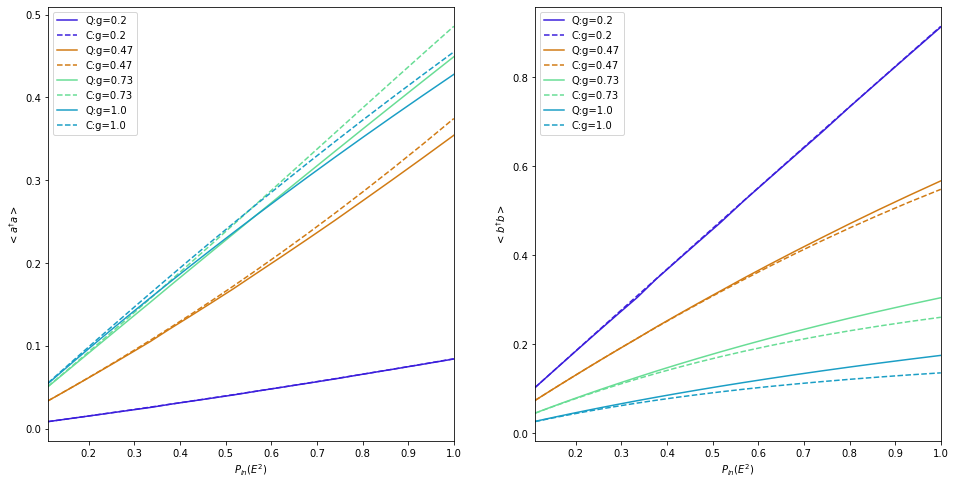

In [21]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol1[i,...,0],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol1[i,...,1],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[0].plot(E_list*E_list,sol2[i,...,0],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,1],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel(r'$<a^{\dagger}a>$')
axes[1].set_ylabel(r'$<b^{\dagger}b>$')    
print("qutip:"+str(t_qutip*1000)+'ms',end='\t')
print("QCLS:"+str(t_cluster*1000)+'ms')

Text(0, 0.5, 'Correlation b$g_{2}$')

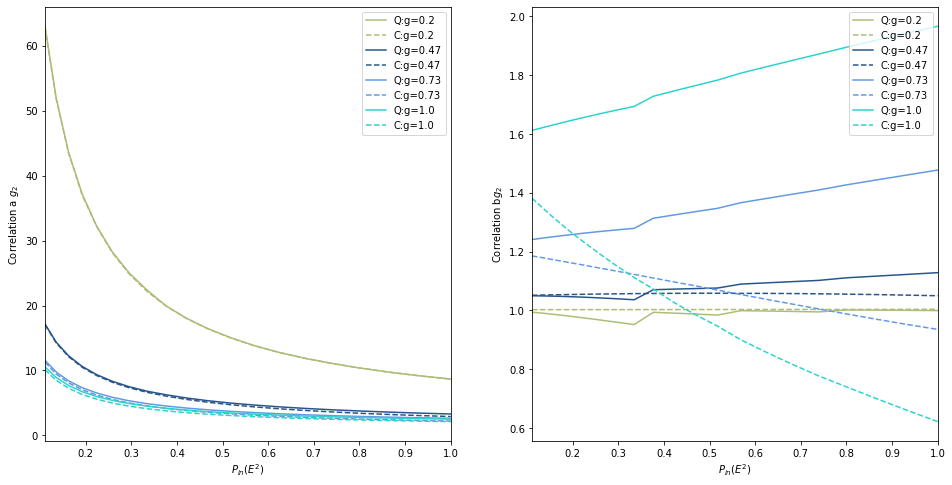

In [22]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
#axes[0].set_ylim(0,1);axes[1].set_ylim(0,1)
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol1[i,...,2],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol1[i,...,3],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[0].plot(E_list*E_list,sol2[i,...,2],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,3],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel('Correlation a '+r'$g_{2}$')
axes[1].set_ylabel('Correlation b'+r'$g_{2}$')